In [58]:
import sys
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
from keras.datasets import mnist
from keras.utils import to_categorical
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.
x_train = numpy.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = numpy.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(numpy.float32)
y_test_cat  = to_categorical(y_test).astype(numpy.float32)

print(y_train_cat.shape)

(60000, 10)


In [61]:
batch_size = 500
latent_dim = 100
dropout_rate = 0.3
start_lr = 0.001
num_classes = 10

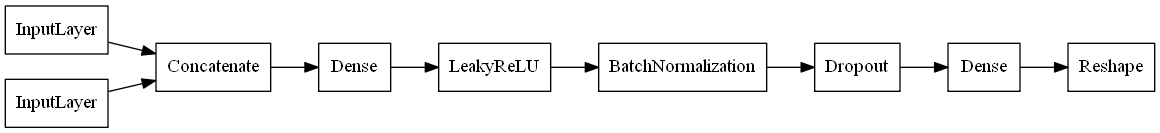

In [62]:
import pydot

from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras.utils import model_to_dot
from keras.utils.vis_utils import plot_model

from IPython.display import SVG


def create_cvae():
    models = {}

    def apply_bn_and_dropout(x):
        return Dropout(dropout_rate)(BatchNormalization()(x))

    input_img = Input(shape=(28, 28, 1))
    flatten_img = Flatten()(input_img)
    input_lbl = Input(shape=(num_classes,), dtype='float32')

    with tf.variable_scope('encoder_model'):
        x = concatenate([flatten_img, input_lbl])
        x = Dense(256, activation='relu')(x)
        x = LeakyReLU()(x)
        x = apply_bn_and_dropout(x)
        x = Dense(128, activation='relu')(x)
        x = LeakyReLU()(x)
        x = apply_bn_and_dropout(x)

        z_mean = Dense(latent_dim)(x)
        z_log_var = Dense(latent_dim)(x)

        def sampling(args):
            z_mean, z_log_var = args
            epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
            return z_mean + K.exp(z_log_var / 2) * epsilon
        l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    encoder_model = Model([input_img, input_lbl], l, name="Encoder")
    models["encoder"] = encoder_model

    z = Input(shape=(latent_dim,))
    input_lbl_d = Input(shape=(num_classes,), dtype='float32')

    with tf.variable_scope('decoder_model'):
        x = concatenate([z, input_lbl_d])
        x = Dense(256)(x)
        x = LeakyReLU()(x)
        x = apply_bn_and_dropout(x)
        x = Dense(28 * 28, activation='sigmoid')(x)
        decoded = Reshape((28, 28, 1))(x)
    decoder_model = Model([z, input_lbl_d], decoded, name='Decoder')
    models["decoder"] = decoder_model
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d], 
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]), 
                              name="CVAE")    
    
    def vae_loss(x, decoded):
        x = K.reshape(x, shape=(batch_size, 28 * 28))
        decoded = K.reshape(decoded, shape=(batch_size, 28 * 28))
        xent_loss = 28 * 28 * binary_crossentropy(x, decoded)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return (xent_loss + kl_loss) / 2 / 28 / 28

    return models, vae_loss

models, vae_loss = create_cvae()
cvae = models["cvae"]
encoder = models["encoder"]
decoder_model = models["decoder"]

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/User/Downloads/graphviz-2.38/release/bin/'

# SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))
# SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(encoder, to_file="saved_models\\conditional_variational_ae\\encoder.png", rankdir='LR', show_layer_names=False)
plot_model(decoder_model, to_file="saved_models\\conditional_variational_ae\\decoder.png", rankdir='LR', show_layer_names=False)

In [63]:
from keras.optimizers import Adam, RMSprop
cvae.compile(optimizer=Adam(start_lr), loss=vae_loss)
cvae.summary()

Model: "CVAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
Encoder (Model)                 (None, 100)          263752      input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 10)           0                                         

In [64]:
digit_size = 28
def plot_digits(*args, invert_colors=False):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = numpy.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors:
        figure = 1-figure

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

n = 15 # Картинка с 15x15 цифр

from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры, берем из обратной функции распределения
grid_x = norm.ppf(numpy.linspace(0.05, 0.99, n))
grid_y = norm.ppf(numpy.linspace(0.05, 0.99, n))

def draw_manifold(generator, lbl, show=True):
    # Рисование цифр из многообразия
    figure = numpy.zeros((digit_size * n, digit_size * n))
    input_lbl = numpy.zeros((1, 10))
    input_lbl[0, lbl] = 1
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = numpy.zeros((1, latent_dim))
            z_sample[:, :2] = numpy.array([[xi, yi]])

            x_decoded = generator.predict([z_sample, input_lbl])
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure

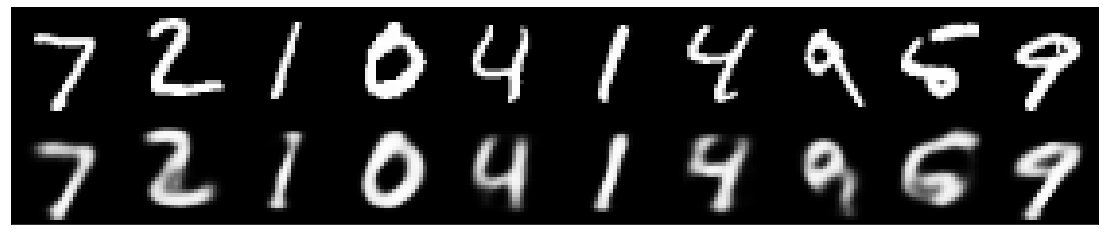

Epoch 43/50
60000/60000 [==============================] - 3s 45us/step - loss: 0.0794 - val_loss: 0.0712
Epoch 44/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.0793 - val_loss: 0.0712
Epoch 45/50
60000/60000 [==============================] - 3s 44us/step - loss: 0.0793 - val_loss: 0.0710
Epoch 46/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0792 - val_loss: 0.0712
Epoch 47/50
60000/60000 [==============================] - 3s 42us/step - loss: 0.0791 - val_loss: 0.0710
Epoch 48/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0792 - val_loss: 0.0710
Epoch 49/50
60000/60000 [==============================] - 2s 41us/step - loss: 0.0791 - val_loss: 0.0710
Epoch 50/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.0791 - val_loss: 0.0709
ALL TRAINING TIME: 142.06499981880188


In [65]:
import time

from IPython.display import clear_output
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard


# Массивы, в которые будем сохранять результаты для последующей визуализации
figs = [[] for x in range(num_classes)]
latent_distrs = [[] for x in range(num_classes)]
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set(list((numpy.arange(0, 59) ** 1.701).astype(numpy.int)) + list(range(10)))

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])
        epochs.append(epoch)


# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')


start_time = time.time()
# Запуск обучения 
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=50,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1)
print(f"ALL TRAINING TIME: %s" % (time.time() - start_time))

# Saving certain models to files.

In [66]:
import os
import json

save_path = os.path.join("saved_models", "conditional_variational_ae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "cvae.json"), "w") as f:
    json.dump(models["cvae"].to_json(), f, indent=4)
models["cvae"].save_weights(os.path.join(save_path, "cvae.h5"))

with open(os.path.join(save_path, "cvae_encoder.json"), "w") as f:
    json.dump(models["encoder"].to_json(), f, indent=4)
models["encoder"].save_weights(os.path.join(save_path, "cvae_encoder.h5"))

with open(os.path.join(save_path, "cvae_decoder.json"), "w") as f:
    json.dump(models["decoder"].to_json(), f, indent=4)
models["decoder"].save_weights(os.path.join(save_path, "cvae_decoder.h5"))

# Reading certain models from files.

In [ ]:
import os

from keras.models import model_from_json
from keras.layers import Input, Dense 
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from keras.layers import concatenate
from keras.models import Model
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K

models = {}

save_path = os.path.join("saved_models", "conditional_variational_ae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "cvae.json"), "r") as f:
    data = f.read()
models["cvae"] = model_from_json(data)
models["cvae"].load_weights(os.path.join(save_path, "cvae.h5"))

with open(os.path.join(save_path, "cvae_encoder.json"), "r") as f:
    data = f.read()
models["encoder"] = model_from_json(data)
models["encoder"].load_weights(os.path.join(save_path, "cvae_encoder.h5"))

with open(os.path.join(save_path, "cvae_decoder.json"), "r") as f:
    data = f.read()
models["decoder"] = model_from_json(data)
models["decoder"].load_weights(os.path.join(save_path, "cvae_decoder.h5"))

# Interpolating a picture of number from one to another

## Get predicted by decoder pictures

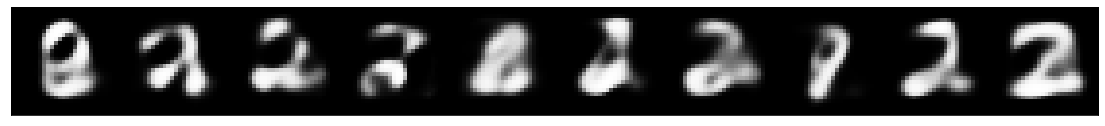

In [79]:
import numpy

decoder_model = models["decoder"]
codes = []
lbls = []

tmp = numpy.zeros(shape=(num_classes,))
tmp[2] = 1

for i in range(10):
    codes.append(numpy.random.normal(size=(latent_dim,)))
    lbls.append(tmp)

predicted = decoder_model.predict([codes, lbls])
plot_digits(predicted)

## Try to interpolate between two pictures

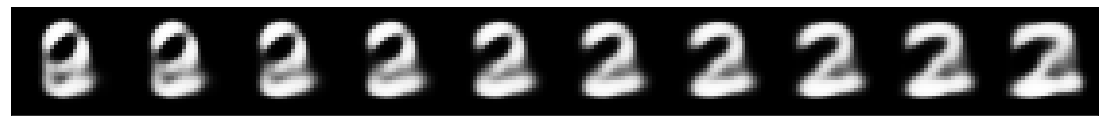

In [80]:
from scipy.interpolate import interp1d

start_code = codes[0]
end_code = codes[9]

num_of_steps = 10

new_codes = []
new_codes.append(start_code)
for i in range(num_of_steps - 2):
    curr_code = []
    for j in range(len(start_code)):
        s = start_code[j]
        e = end_code[j]

        curr_code.append(s + ((e - s) / num_of_steps) * (i + 1))
    new_codes.append(numpy.array(curr_code))
new_codes.append(end_code)

new_predicted = decoder_model.predict([new_codes, lbls])
plot_digits(new_predicted)

In [ ]:
draw_manifold(decoder_model, 6)

# Build GAN with decoder as generative net

## Simple discriminator - probably doesn't work correctly

In [ ]:
import tensorflow as tf
from keras.layers import Dropout, BatchNormalization, Reshape, Flatten
from keras.layers import Dense, Input, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam


input_discrim_img = Input(shape=(28, 28, 1))
flatten_discrim_img = Flatten()(input_discrim_img)
input_lbl = Input(shape=(num_classes,), dtype='float32')

x = concatenate([flatten_discrim_img, input_lbl])
x = Dense(1024)(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)

x = Dense(512)(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)

x = Dense(256)(x)
x = LeakyReLU()(x)
x = Dropout(dropout_rate)(x)

x = Dense(1, activation='sigmoid')(x)

discriminator_model = Model([input_discrim_img, input_lbl], x, name="Discriminator")
discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam())
discriminator_model.summary()

In [ ]:
discriminator_model.trainable = False

gan_input_code = Input(shape=(latent_dim,))
gan_input_lbl = Input(shape=(num_classes,))

fake_image = decoder_model([gan_input_code, gan_input_lbl])

gan_output = discriminator_model([fake_image, gan_input_lbl])

gan = Model([gan_input_code, gan_input_lbl], gan_output, name="GAN with decoder")
gan.compile(loss='binary_crossentropy', optimizer=Adam())
gan.summary()

In [ ]:
import time


# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

epochs = 10
batch_size = 16
steps_per_epoch = 3750
epochs_to_check = [0, 9, 19, 29, 39, 49, 59]

print(f'START TRAINING...')
start_time = time.time()
for epoch in range(epochs):
    start_epoch_time = time.time()
    for batch in range(steps_per_epoch):
        b0, b1 = next(train_batches_it)
        noise = numpy.random.randn(batch_size, latent_dim)

        fake_x = decoder_model.predict([noise, b1])

        x1 = numpy.concatenate((b0, fake_x))
        x2 = numpy.concatenate((b1, b1))

        disc_y = numpy.zeros(2 * batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator_model.train_on_batch([x1, x2], disc_y)

        gen_y = numpy.ones(batch_size)
        g_loss = gan.train_on_batch([noise, b1], gen_y)

    print(f'Epoch: %s \t Discriminator Loss: %s \t\t Generator Loss: %s \t\t Elapsed time for epoch: %s' % (epoch, d_loss, g_loss, time.time() - start_epoch_time))
    clear_output()
    b0, b1 = next(test_batches_it)
    noise = numpy.random.normal(0, 1, size=(batch_size, latent_dim))    

    decoded = decoder_model.predict([noise, b1], batch_size=batch_size)
    plot_digits(b0[:n_compare], decoded[:n_compare])

print(f'\nELAPSED TIME FOR ALL TRAINING: %s' % (time.time() - start_time))

## !!!!!! Complicated model of discriminator and GAN

In [60]:
# Регистрация сессии в keras
from keras import backend as K
import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [ ]:
batch_size = 64
batch_shape = (batch_size, 28, 28, 1)
latent_dim = 100
num_classes = 10
dropout_rate = 0.3
gamma = 1

In [70]:
def gen_batch(x, y):
    n_batches = x.shape[0] // batch_size
    while (True):
        idxs = numpy.random.permutation(y.shape[0])
        x = x[idxs]
        y = y[idxs]
        for i in range(n_batches):
            yield x[batch_size * i:batch_size * (i + 1)], y[batch_size * i:batch_size * (i + 1)]

train_batches_it = gen_batch(x_train, y_train_cat)
test_batches_it = gen_batch(x_test, y_test_cat)

In [71]:
x_ = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name='image')
y_ = tf.placeholder(tf.float32, shape=(None, num_classes), name='labels')
z_ = tf.placeholder(tf.float32, shape=(None, latent_dim), name='z')

img = Input(tensor=x_)
lbl = Input(tensor=y_)
z = Input(tensor=z_)

In [72]:
from keras.layers import Dropout, BatchNormalization, Reshape, Flatten, RepeatVector
from keras.layers import Lambda, Dense, Input, Conv2D, MaxPool2D, UpSampling2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model


def add_units_to_conv2d(conv2, units):
    dim1 = int(conv2.shape[1])
    dim2 = int(conv2.shape[2])
    dimc = int(units.shape[1])

    repeat_n = dim1 * dim2
    units_repeat = RepeatVector(repeat_n)(lbl)
    units_repeat = Reshape((dim1, dim2, dimc))(units_repeat)
    return concatenate([conv2, units_repeat])


with tf.variable_scope('discrim'):
    x = Conv2D(128, kernel_size=(7, 7), strides=(2, 2), padding='same')(img)
    x = add_units_to_conv2d(x, lbl)
    x = LeakyReLU()(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPool2D((2, 2), padding='same')(x)

    l = Conv2D(128, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(l)
    x = Dropout(dropout_rate)(x)

    h = Flatten()(x)
    d = Dense(1, activation='sigmoid')(h)
discrim = Model([img, lbl], d, name="Discriminator")

In [ ]:
with tf.variable_scope('generator'):
    x = concatenate([z, lbl])
    x = Dense(7 * 7 * 64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Reshape((7, 7, 64))(x)
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = UpSampling2D(size=(2, 2))(x)

    generated = Conv2D(1, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)
generator = Model([z, lbl], generated, name='generator')

In [73]:
generated_z = decoder_model([z, lbl])
discr_img = discrim([img, lbl])
discr_gen_z = discrim([generated_z, lbl])

gan_model = Model([z, lbl], discr_gen_z, name="GAN")
gan = gan_model([z, lbl])

In [74]:
log_dis_img = tf.reduce_mean(-tf.log(discr_img + 1e-10))
log_dis_gen_z = tf.reduce_mean(-tf.log(1. - discr_gen_z + 1e-10))

L_gen = -log_dis_gen_z
L_dis = 0.5 * (log_dis_gen_z + log_dis_img)

In [75]:
optimizer_gen = tf.train.RMSPropOptimizer(0.0003)
optimizer_dis = tf.train.RMSPropOptimizer(0.0001)

generator_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'decoder_model')
discrim_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discrim')

step_gen = optimizer_gen.minimize(L_gen, var_list=generator_vars)
step_dis = optimizer_dis.minimize(L_dis, var_list=discrim_vars)

In [76]:
sess.run(tf.global_variables_initializer())

In [78]:
# After tf.global_variables_initializer() the decoder_model is null
# We need to load weights from file
decoder_model.load_weights(os.path.join(save_path, "cvae_decoder.h5"))

In [81]:
def step(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_gen], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

def step_d(image, label, zp):
    l_dis, _ = sess.run([L_dis, step_dis], feed_dict={z:zp, lbl:label, img:image, K.learning_phase():1})
    return l_dis

In [82]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
figs = [[] for x in range(num_classes)]
periods = []

save_periods = list(range(100)) + list(range(100, 1000, 10))

n = 15 # Картинка с 15x15 цифр
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры, берем из обратной функции распределения
grid_x = norm.ppf(numpy.linspace(0.05, 0.95, n))
grid_y = norm.ppf(numpy.linspace(0.05, 0.95, n))
def draw_manifold(label, show=True):
    # Рисование цифр из многообразия
    figure = numpy.zeros((28 * n, 28 * n))
    input_lbl = numpy.zeros(shape=(1, num_classes))
    input_lbl[0, label] = 1.
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = numpy.zeros(shape=(1, latent_dim))
            z_sample[0, :2] = numpy.array([[xi, yi]])

            x_generated = sess.run(generated_z, feed_dict={z:z_sample, lbl:input_lbl, K.learning_phase():0})
            digit = x_generated[0].squeeze()
            figure[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit
    if show:
        # Визуализация
        plt.figure(figsize=(10, 10))
        plt.imshow(figure, cmap='Greys_r')
        plt.grid(False)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.show()
    return figure


n_compare = 10
def on_n_period(period):
    clear_output() # Не захламляем output

    # Рисование многообразия для рандомного y
    draw_lbl = numpy.random.randint(0, num_classes)    
    print(draw_lbl)
    for label in range(num_classes):
        figs[label].append(draw_manifold(label, show=label==draw_lbl))

    periods.append(period)

0


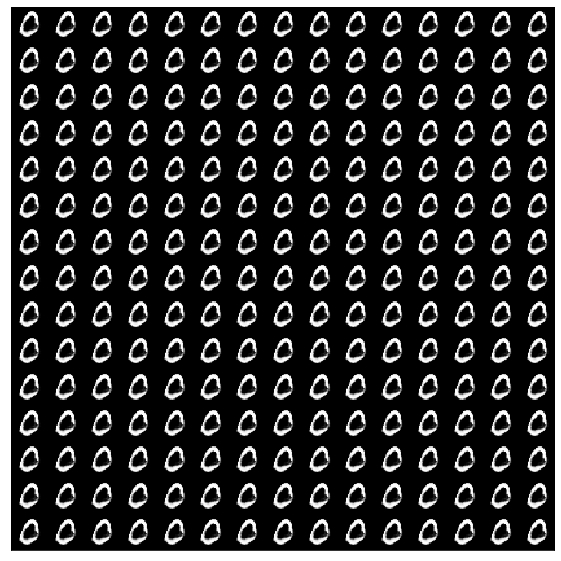

0.4593547
....................0.4891212
....................0.44690412
....................0.43292296
....................0.4595781
....................0.45042938
....................0.4713417
....................0.4345797
....................0.43023056
....................0.42344528
...................

In [83]:
batches_per_period = 20 # Как часто сохранять картинки
k_step = 5 # Количество шагов, которые могут делать дискриминатор и генератор во внутреннем цикле

for i in range(5000):
    print('.', end='')
    # Достанем новый батч
    b0, b1 = next(train_batches_it)
    zp = numpy.random.randn(batch_size, latent_dim)
    # Шаги обучения дискриминатора
    for j in range(k_step):
        l_d = step_d(b0, b1, zp)
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)
        if l_d < 1.0:
            break

    # Шаги обучения генератора
    for j in range(k_step):
        l_d = step(b0, b1, zp)
        if l_d > 0.4:
            break
        b0, b1 = next(train_batches_it)
        zp = numpy.random.randn(batch_size, latent_dim)

    # Периодическое рисование результата
    if not i % batches_per_period:
        period = i // batches_per_period
        if period in save_periods:
            on_n_period(period)
        print(l_d)

# DRAWING SCRIPTS FOR TESTING

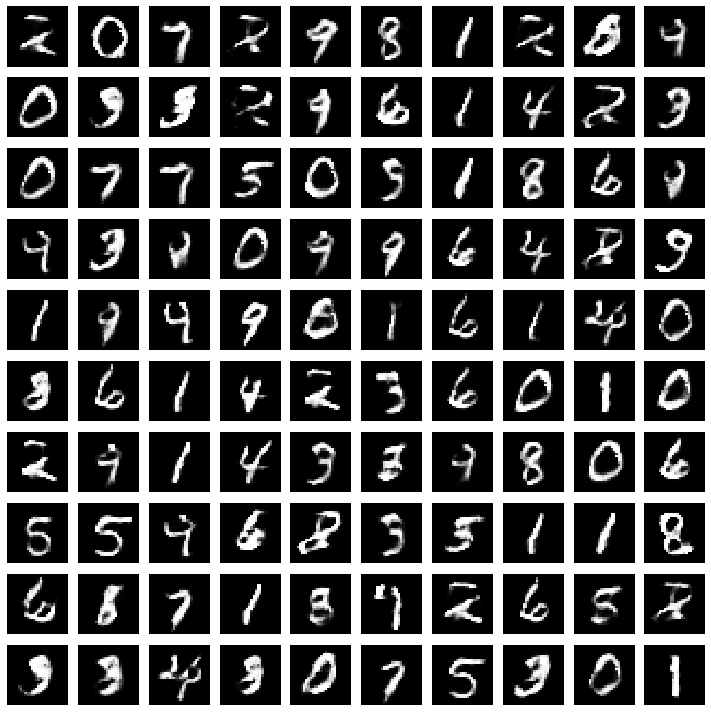

In [86]:
noise = numpy.random.normal(0, 1, size=(batch_size, latent_dim))
lbls = y_train_cat[numpy.random.randint(0, x_train.shape[0], size=batch_size)]
generated_images = decoder_model.predict([noise, lbls])
plt.figure(figsize=(10, 10))

for i, image in enumerate(generated_images[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image.reshape((28, 28)), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

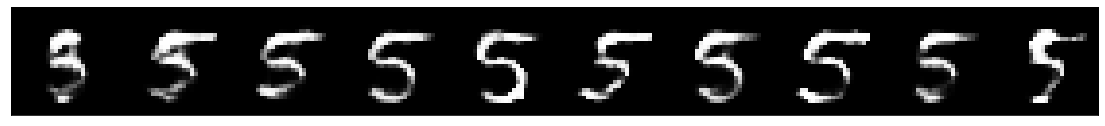

In [128]:
import numpy

codes = []
lbls = []

tmp = numpy.zeros(shape=(num_classes,))
tmp[5]= 1

for i in range(10):
    codes.append(numpy.random.normal(size=(latent_dim,)))
    lbls.append(tmp)

predicted = decoder_model.predict([codes, lbls])
plot_digits(predicted)

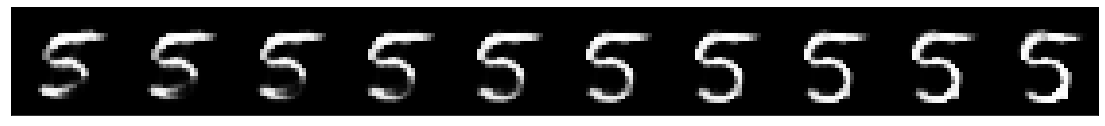

In [129]:
start_code = codes[2]
end_code = codes[4]

num_of_steps = 10

new_codes = []
new_codes.append(start_code)
for i in range(num_of_steps - 2):
    curr_code = []
    for j in range(len(start_code)):
        s = start_code[j]
        e = end_code[j]

        curr_code.append(s + ((e - s) / num_of_steps) * (i + 1))
    new_codes.append(numpy.array(curr_code))
new_codes.append(end_code)

new_predicted = decoder_model.predict([new_codes, lbls])
plot_digits(new_predicted)